Starting DDoS Detection System
DDoS Attack Detection System - Fixed Implementation

[1/6] Loading and filtering data...
STEP 1: Loading and Filtering Data
Original data shape: (2219201, 63)
Filtered data shape: (1953620, 63)

[2/6] Initial data splitting...
Training set: (1172172, 62)
Validation set: (390724, 62)
Test set: (390724, 62)

[3/6] Feature processing...
Removing 6 constant columns: ['icmp.transmit_timestamp', 'icmp.unused', 'http.request.uri.query', 'http.tls_port', 'dns.qry.type']...
Dropped 14 unnecessary feature columns
Dropping high cardinality categorical column: mqtt.conack.flags
Final feature dimensions: (1172172, 41)

[4/6] Creating data loaders...

[5/6] Setting up and training model...
Using device: cuda
Epoch [10/100], Train Loss: 0.0002, Val Loss: 0.0001, Val F1 (DDoS): 1.0000
Early stopping at epoch 11

Model Evaluation Results
Accuracy: 1.0000
Precision: 1.0000
Recall: 0.9999
F1-Score: 1.0000
AUC-ROC: 0.9999


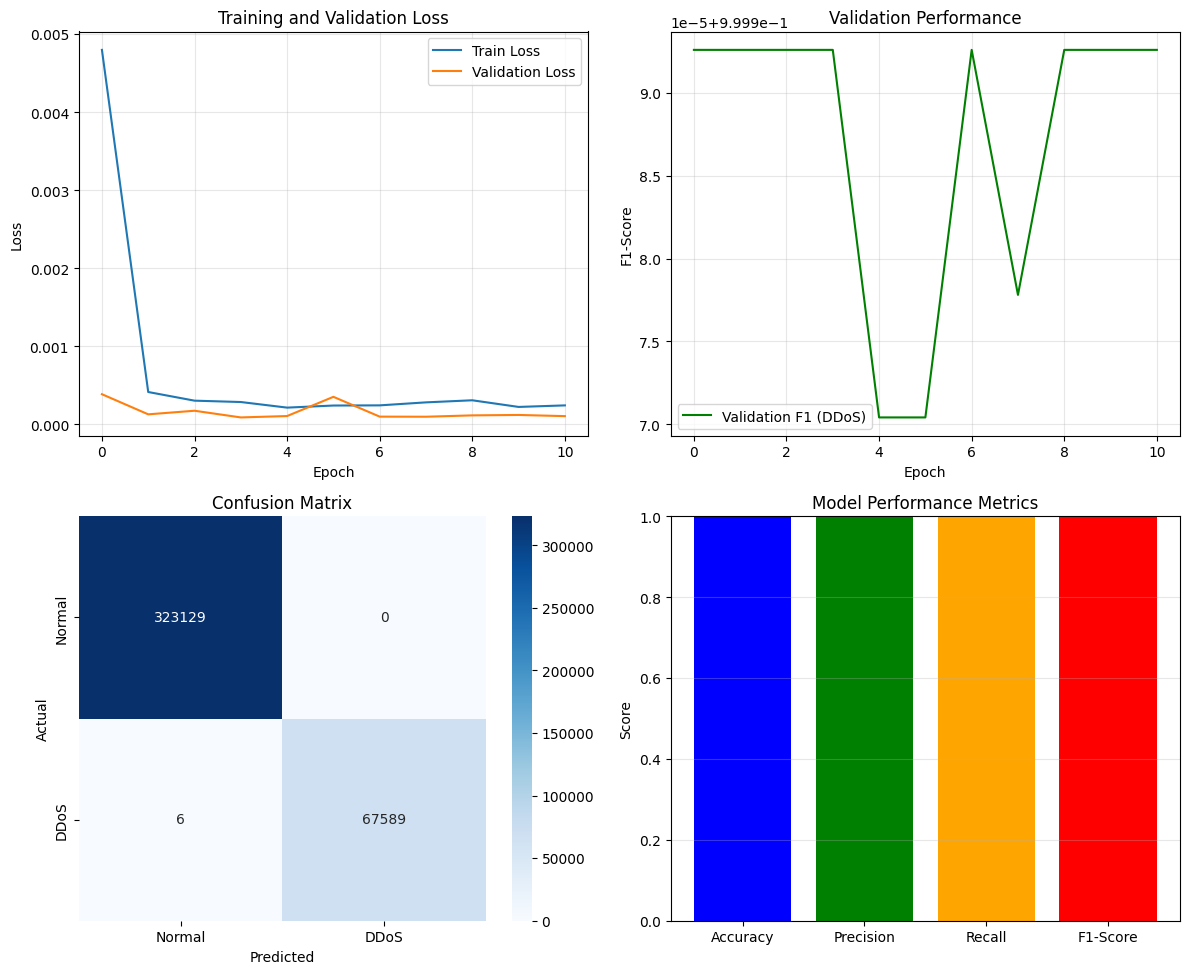


Detailed Classification Report
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00    323129
        DDoS       1.00      1.00      1.00     67595

    accuracy                           1.00    390724
   macro avg       1.00      1.00      1.00    390724
weighted avg       1.00      1.00      1.00    390724


Results saved to 'ddos_detection_report_fixed.txt'
Charts saved to 'ddos_detection_results_fixed.png'

Experiment Complete


In [1]:
"""
Corrected DDoS Detection System for Edge-IIoTset Dataset
Fixed issues:
1. Eliminated data leakage by moving preprocessing after split
2. Replaced inappropriate CNN with proper MLP for tabular data
3. Fixed autoencoder validation logic
4. Added proper evaluation metrics for imbalanced data
5. Ensured fair model comparison
6. Removed misleading feasibility test
"""

# ============ IMPORTS AND SETUP ============
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.backends.cudnn.deterministic = True

# ============ 1. DATA LOADING AND INITIAL FILTERING ============
def load_and_filter_data(filepath, binary_classification=True):
    """
    Load data and perform initial filtering (no feature engineering)
    """
    print("=" * 60)
    print("STEP 1: Loading and Filtering Data")
    print("=" * 60)
    
    # Load dataset
    df = pd.read_csv(filepath, low_memory=False)
    print(f"Original data shape: {df.shape}")
    
    # Keep only Normal and DDoS related data
    valid_attacks = ['Normal', 'DDoS_TCP', 'DDoS_UDP', 'DDoS_HTTP', 'DDoS_ICMP']
    df_filtered = df[df['Attack_type'].isin(valid_attacks)].copy()
    print(f"Filtered data shape: {df_filtered.shape}")
    
    # Create binary labels
    if binary_classification:
        df_filtered['target'] = df_filtered['Attack_type'].apply(
            lambda x: 0 if x == 'Normal' else 1
        )
    else:
        label_mapping = {
            'Normal': 0,
            'DDoS_TCP': 1,
            'DDoS_UDP': 2,
            'DDoS_HTTP': 3,
            'DDoS_ICMP': 4
        }
        df_filtered['target'] = df_filtered['Attack_type'].map(label_mapping)
    
    return df_filtered

# ============ 2. FEATURE PROCESSING CLASS (NO LEAKAGE) ============
class FeatureProcessor:
    """
    Feature processor that prevents data leakage by fitting only on training data
    """
    def __init__(self):
        self.scaler = StandardScaler()
        self.constant_cols = None
        self.categorical_encoders = {}
        self.feature_columns = None
        
    def fit_transform(self, X_train):
        """Fit preprocessing on training data and transform it"""
        X_train = X_train.copy()
        
        # 1. Identify and remove constant columns
        constant_cols = [col for col in X_train.columns if X_train[col].nunique() == 1]
        if constant_cols:
            print(f"Removing {len(constant_cols)} constant columns: {constant_cols[:5]}...")
            X_train = X_train.drop(columns=constant_cols)
            self.constant_cols = constant_cols
        
        # 2. Remove unnecessary columns (protocol-specific identifiers)
        drop_columns = [
            "frame.time", "ip.src_host", "ip.dst_host",
            "arp.src.proto_ipv4", "arp.dst.proto_ipv4",
            "http.file_data", "http.request.full_uri",
            "icmp.transmit_timestamp", "http.request.uri.query",
            "tcp.options", "tcp.payload", "tcp.srcport",
            "tcp.dstport", "udp.port", "mqtt.msg",
            "Attack_type", "Attack_label"
        ]
        
        # Only drop columns that exist
        existing_drop = [col for col in drop_columns if col in X_train.columns]
        X_train = X_train.drop(columns=existing_drop)
        print(f"Dropped {len(existing_drop)} unnecessary feature columns")
        
        # 3. Handle categorical variables (only low cardinality ones)
        categorical_cols = X_train.select_dtypes(include=['object']).columns
        for col in categorical_cols:
            if X_train[col].nunique() < 10:
                # Use label encoding for low cardinality (safer than one-hot for DL)
                le = LabelEncoder()
                X_train[col] = le.fit_transform(X_train[col].astype(str).fillna('missing'))
                self.categorical_encoders[col] = le
            else:
                # Drop high cardinality categorical variables
                print(f"Dropping high cardinality categorical column: {col}")
                X_train = X_train.drop(columns=[col])
        
        # 4. Ensure all data is numeric
        X_train = X_train.apply(pd.to_numeric, errors='coerce')
        
        # 5. Fill missing values with median (fit on train only)
        for col in X_train.columns:
            if X_train[col].isnull().any():
                median_val = X_train[col].median()
                X_train[col] = X_train[col].fillna(median_val)
        
        # 6. Store feature columns and fit scaler
        self.feature_columns = X_train.columns.tolist()
        X_scaled = self.scaler.fit_transform(X_train)
        
        print(f"Final feature dimensions: {X_scaled.shape}")
        return X_scaled
    
    def transform(self, X_data):
        """Transform validation/test data using fitted parameters"""
        X_data = X_data.copy()
        
        # Remove constant columns
        if self.constant_cols:
            X_data = X_data.drop(columns=[col for col in self.constant_cols if col in X_data.columns])
        
        # Remove the same columns as in training
        drop_columns = [
            "frame.time", "ip.src_host", "ip.dst_host",
            "arp.src.proto_ipv4", "arp.dst.proto_ipv4",
            "http.file_data", "http.request.full_uri",
            "icmp.transmit_timestamp", "http.request.uri.query",
            "tcp.options", "tcp.payload", "tcp.srcport",
            "tcp.dstport", "udp.port", "mqtt.msg",
            "Attack_type", "Attack_label"
        ]
        existing_drop = [col for col in drop_columns if col in X_data.columns]
        X_data = X_data.drop(columns=existing_drop)
        
        # Apply categorical encoding
        for col, encoder in self.categorical_encoders.items():
            if col in X_data.columns:
                X_data[col] = encoder.transform(X_data[col].astype(str).fillna('missing'))
        
        # Keep only the features that were in training
        if self.feature_columns:
            missing_cols = set(self.feature_columns) - set(X_data.columns)
            extra_cols = set(X_data.columns) - set(self.feature_columns)
            
            if missing_cols:
                # Add missing columns with zeros
                for col in missing_cols:
                    X_data[col] = 0
            
            if extra_cols:
                # Remove extra columns
                X_data = X_data.drop(columns=list(extra_cols))
            
            # Ensure correct order
            X_data = X_data[self.feature_columns]
        
        # Ensure numeric and fill missing
        X_data = X_data.apply(pd.to_numeric, errors='coerce')
        for col in X_data.columns:
            if X_data[col].isnull().any():
                # Use 0 for missing in validation/test (or could use train median if stored)
                X_data[col] = X_data[col].fillna(0)
        
        # Scale
        X_scaled = self.scaler.transform(X_data)
        return X_scaled

# ============ 3. DEEP LEARNING MODELS (PROPER ARCHITECTURES) ============
class DDoSDetectorMLP(nn.Module):
    """
    MLP model for DDoS detection - appropriate for tabular data
    """
    def __init__(self, input_dim, num_classes=2, dropout_rate=0.3):
        super(DDoSDetectorMLP, self).__init__()
        
        # MLP architecture
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(dropout_rate/2),
        )
        
        # Classification head
        self.classifier = nn.Linear(64, num_classes)
        
    def forward(self, x):
        features = self.mlp(x)
        output = self.classifier(features)
        return output


class AutoencoderDDoS(nn.Module):
    """
    Autoencoder for anomaly detection (trained only on normal data)
    """
    def __init__(self, input_dim, latent_dim=32):
        super(AutoencoderDDoS, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            
            nn.Linear(64, latent_dim)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            
            nn.Linear(128, input_dim)
        )
    
    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed
    
    def get_reconstruction_error(self, x):
        with torch.no_grad():
            reconstructed = self.forward(x)
            error = F.mse_loss(reconstructed, x, reduction='none').mean(dim=1)
        return error

# ============ 4. TRAINING FUNCTIONS WITH PROPER VALIDATION ============
def train_classifier(model, train_loader, val_loader, criterion, optimizer, 
                     device, num_epochs=100, patience=10):
    """
    Train classifier model with proper validation
    """
    train_losses = []
    val_losses = []
    val_f1_scores = []
    best_f1 = 0.0
    patience_counter = 0
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * batch_X.size(0)
        
        train_loss = train_loss / len(train_loader.dataset)
        train_losses.append(train_loss)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                val_loss += loss.item() * batch_X.size(0)
                
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(batch_y.cpu().numpy())
        
        val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(val_loss)
        
        # Calculate F1-score for minority class
        val_f1 = f1_score(all_labels, all_preds, average='binary', pos_label=1)
        val_f1_scores.append(val_f1)
        
        # Early stopping based on F1-score
        if val_f1 > best_f1:
            best_f1 = val_f1
            patience_counter = 0
            # Save best model
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_f1': val_f1,
            }, 'best_classifier.pth')
        else:
            patience_counter += 1
        
        # Print progress every 10 epochs
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Train Loss: {train_loss:.4f}, '
                  f'Val Loss: {val_loss:.4f}, '
                  f'Val F1 (DDoS): {val_f1:.4f}')
        
        # Early stopping
        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break
    
    # Load best model
    checkpoint = torch.load('best_classifier.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
    
    return model, train_losses, val_losses, val_f1_scores


def train_autoencoder(model, normal_train_loader, val_loader, criterion, 
                      optimizer, device, num_epochs=100, patience=10):
    """
    Train autoencoder only on normal data
    """
    train_losses = []
    val_losses = []
    best_loss = float('inf')
    patience_counter = 0
    
    # Train only on normal data
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        
        for batch_X, _ in normal_train_loader:  # Ignore labels, all are normal
            batch_X = batch_X.to(device)
            
            optimizer.zero_grad()
            reconstructed = model(batch_X)
            loss = criterion(reconstructed, batch_X)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * batch_X.size(0)
        
        train_loss = train_loss / len(normal_train_loader.dataset)
        train_losses.append(train_loss)
        
        # Validation on all validation data
        model.eval()
        val_loss = 0.0
        
        with torch.no_grad():
            for batch_X, _ in val_loader:
                batch_X = batch_X.to(device)
                reconstructed = model(batch_X)
                loss = criterion(reconstructed, batch_X)
                val_loss += loss.item() * batch_X.size(0)
        
        val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(val_loss)
        
        # Early stopping based on validation loss
        if val_loss < best_loss:
            best_loss = val_loss
            patience_counter = 0
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_loss,
            }, 'best_autoencoder.pth')
        else:
            patience_counter += 1
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Train Loss: {train_loss:.4f}, '
                  f'Val Loss: {val_loss:.4f}')
        
        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break
    
    checkpoint = torch.load('best_autoencoder.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
    
    return model, train_losses, val_losses

# ============ 5. EVALUATION FUNCTIONS ============
def evaluate_classifier(model, test_loader, device, binary=True):
    """
    Evaluate classifier model
    """
    model.eval()
    all_predictions = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            
            outputs = model(batch_X)
            probs = F.softmax(outputs, dim=1)
            
            if binary:
                class_probs = probs[:, 1]
            else:
                class_probs = probs
            
            _, predictions = torch.max(outputs, 1)
            
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())
            all_probs.extend(class_probs.cpu().numpy())
    
    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, 
                              average='binary' if binary else 'weighted', pos_label=1)
    recall = recall_score(all_labels, all_predictions, 
                         average='binary' if binary else 'weighted', pos_label=1)
    f1 = f1_score(all_labels, all_predictions, 
                 average='binary' if binary else 'weighted', pos_label=1)
    
    if binary:
        try:
            auc_roc = roc_auc_score(all_labels, all_probs)
        except:
            auc_roc = 0.0
    else:
        auc_roc = 0.0
    
    cm = confusion_matrix(all_labels, all_predictions)
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc_roc': auc_roc,
        'confusion_matrix': cm,
        'predictions': all_predictions,
        'labels': all_labels,
        'probabilities': all_probs
    }


def evaluate_autoencoder(model, test_loader, threshold, device):
    """
    Evaluate autoencoder with fixed threshold
    """
    model.eval()
    all_predictions = []
    all_labels = []
    all_scores = []
    
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            
            # Get reconstruction errors
            errors = model.get_reconstruction_error(batch_X)
            
            # Classify as anomaly (DDoS) if error > threshold
            predictions = (errors > threshold).long()
            
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())
            all_scores.extend(errors.cpu().numpy())
    
    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, average='binary', pos_label=1)
    recall = recall_score(all_labels, all_predictions, average='binary', pos_label=1)
    f1 = f1_score(all_labels, all_predictions, average='binary', pos_label=1)
    
    try:
        auc_roc = roc_auc_score(all_labels, all_scores)
    except:
        auc_roc = 0.0
    
    cm = confusion_matrix(all_labels, all_predictions)
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc_roc': auc_roc,
        'confusion_matrix': cm,
        'predictions': all_predictions,
        'labels': all_labels,
        'scores': all_scores
    }

# ============ 6. MAIN PIPELINE (NO DATA LEAKAGE) ============
def main():
    """
    Main pipeline for DDoS detection with proper data handling
    """
    print("=" * 60)
    print("DDoS Attack Detection System - Fixed Implementation")
    print("=" * 60)
    
    # File path - adjust as needed
    filepath = '/kaggle/input/edgeiiotset-cyber-security-dataset-of-iot-iiot/Edge-IIoTset dataset/Selected dataset for ML and DL/DNN-EdgeIIoT-dataset.csv'
    
    # Configuration
    binary_classification = True  # Set to False for multi-class
    model_choice = 'mlp'  # 'mlp' or 'autoencoder'
    
    # 1. Load and filter data
    print("\n[1/6] Loading and filtering data...")
    df = load_and_filter_data(filepath, binary_classification)
    
    # 2. Initial split (before any feature processing)
    print("\n[2/6] Initial data splitting...")
    
    # Separate features and target (without processing)
    X = df.drop(columns=['target', 'Attack_type'])
    y = df['target'].values
    
    # Stratified split to maintain class distribution
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42  # 0.25 * 0.8 = 0.2
    )
    
    print(f"Training set: {X_train.shape}")
    print(f"Validation set: {X_val.shape}")
    print(f"Test set: {X_test.shape}")
    
    # 3. Feature processing (NO LEAKAGE - fit only on train)
    print("\n[3/6] Feature processing...")
    processor = FeatureProcessor()
    
    # Fit and transform training data
    X_train_processed = processor.fit_transform(X_train)
    
    # Transform validation and test data using training parameters
    X_val_processed = processor.transform(X_val)
    X_test_processed = processor.transform(X_test)
    
    # 4. Convert to PyTorch tensors
    print("\n[4/6] Creating data loaders...")
    X_train_tensor = torch.FloatTensor(X_train_processed)
    y_train_tensor = torch.LongTensor(y_train)
    X_val_tensor = torch.FloatTensor(X_val_processed)
    y_val_tensor = torch.LongTensor(y_val)
    X_test_tensor = torch.FloatTensor(X_test_processed)
    y_test_tensor = torch.LongTensor(y_test)
    
    # Create data loaders
    batch_size = 512
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # For autoencoder: create separate loader with only normal data
    normal_mask = y_train == 0
    normal_train_tensor = X_train_tensor[normal_mask]
    normal_y_tensor = y_train_tensor[normal_mask]
    normal_train_dataset = TensorDataset(normal_train_tensor, normal_y_tensor)
    normal_train_loader = DataLoader(normal_train_dataset, batch_size=batch_size, shuffle=True)
    
    # 5. Model setup and training
    print("\n[5/6] Setting up and training model...")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    if model_choice == 'mlp':
        # MLP classifier
        model = DDoSDetectorMLP(
            input_dim=X_train_processed.shape[1],
            num_classes=2 if binary_classification else 5
        )
        
        # Use class-weighted loss for imbalanced data
        class_counts = np.bincount(y_train)
        class_weights = 1.0 / class_counts
        class_weights = torch.FloatTensor(class_weights / class_weights.sum())
        criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
        
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
        
        model = model.to(device)
        
        # Train classifier
        model, train_losses, val_losses, val_metrics = train_classifier(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            criterion=criterion,
            optimizer=optimizer,
            device=device,
            num_epochs=100,
            patience=10
        )
        
        # Evaluate classifier
        results = evaluate_classifier(
            model=model,
            test_loader=test_loader,
            device=device,
            binary=binary_classification
        )
        
        val_accuracies = val_metrics  # Actually F1 scores
        
    else:  # Autoencoder
        model = AutoencoderDDoS(
            input_dim=X_train_processed.shape[1],
            latent_dim=32
        )
        
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
        
        model = model.to(device)
        
        # Train autoencoder on normal data only
        model, train_losses, val_losses = train_autoencoder(
            model=model,
            normal_train_loader=normal_train_loader,
            val_loader=val_loader,
            criterion=criterion,
            optimizer=optimizer,
            device=device,
            num_epochs=100,
            patience=10
        )
        
        # Calculate threshold from training reconstruction errors
        print("\nCalculating anomaly threshold...")
        model.eval()
        train_errors = []
        with torch.no_grad():
            for batch_X, _ in normal_train_loader:
                batch_X = batch_X.to(device)
                errors = model.get_reconstruction_error(batch_X)
                train_errors.extend(errors.cpu().numpy())
        
        # Set threshold as mean + 3*std of normal data reconstruction errors
        threshold = np.mean(train_errors) + 3 * np.std(train_errors)
        print(f"Anomaly threshold: {threshold:.6f}")
        
        # Evaluate autoencoder
        results = evaluate_autoencoder(
            model=model,
            test_loader=test_loader,
            threshold=threshold,
            device=device
        )
        
        val_accuracies = [0] * len(val_losses)  # Placeholder
    
    # 6. Results visualization
    print("\n" + "=" * 60)
    print("Model Evaluation Results")
    print("=" * 60)
    print(f"Accuracy: {results['accuracy']:.4f}")
    print(f"Precision: {results['precision']:.4f}")
    print(f"Recall: {results['recall']:.4f}")
    print(f"F1-Score: {results['f1']:.4f}")
    if binary_classification:
        print(f"AUC-ROC: {results['auc_roc']:.4f}")
    
    # Create visualizations
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Loss curves
    axes[0, 0].plot(train_losses, label='Train Loss')
    axes[0, 0].plot(val_losses, label='Validation Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Training and Validation Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # F1-score or placeholder curve
    if model_choice == 'mlp':
        axes[0, 1].plot(val_accuracies, label='Validation F1 (DDoS)', color='green')
        axes[0, 1].set_ylabel('F1-Score')
    else:
        axes[0, 1].plot(val_losses, label='Validation Loss', color='green')
        axes[0, 1].set_ylabel('Loss')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_title('Validation Performance')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Confusion matrix
    cm = results['confusion_matrix']
    if binary_classification:
        labels = ['Normal', 'DDoS']
    else:
        labels = ['Normal', 'DDoS_TCP', 'DDoS_UDP', 'DDoS_HTTP', 'DDoS_ICMP']
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels, ax=axes[1, 0])
    axes[1, 0].set_title('Confusion Matrix')
    axes[1, 0].set_xlabel('Predicted')
    axes[1, 0].set_ylabel('Actual')
    
    # Metrics comparison
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    values = [results['accuracy'], results['precision'],
              results['recall'], results['f1']]
    
    axes[1, 1].bar(metrics, values, color=['blue', 'green', 'orange', 'red'])
    axes[1, 1].set_ylim([0, 1.0])
    axes[1, 1].set_title('Model Performance Metrics')
    axes[1, 1].set_ylabel('Score')
    axes[1, 1].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig('ddos_detection_results_fixed.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 7. Detailed report
    print("\n" + "=" * 60)
    print("Detailed Classification Report")
    print("=" * 60)
    
    target_names = ['Normal', 'DDoS'] if binary_classification else labels
    report = classification_report(
        results['labels'],
        results['predictions'],
        target_names=target_names
    )
    print(report)
    
    # Save results
    with open('ddos_detection_report_fixed.txt', 'w') as f:
        f.write("DDoS Attack Detection Results (Fixed Implementation)\n")
        f.write("=" * 50 + "\n\n")
        f.write(f"Model type: {model_choice.upper()}\n")
        f.write(f"Classification type: {'Binary (Normal vs DDoS)' if binary_classification else 'Multi-class (DDoS types)'}\n")
        f.write(f"Accuracy: {results['accuracy']:.4f}\n")
        f.write(f"Precision: {results['precision']:.4f}\n")
        f.write(f"Recall: {results['recall']:.4f}\n")
        f.write(f"F1-Score: {results['f1']:.4f}\n")
        if binary_classification:
            f.write(f"AUC-ROC: {results['auc_roc']:.4f}\n")
        f.write("\nClassification report:\n")
        f.write(report)
    
    print("\nResults saved to 'ddos_detection_report_fixed.txt'")
    print("Charts saved to 'ddos_detection_results_fixed.png'")
    
    return results


# ============ 7. FAIR MODEL COMPARISON ============
def run_fair_comparison():
    """
    Fair comparison between models using same preprocessing
    """
    print("\n" + "=" * 60)
    print("Fair Model Comparison: MLP vs Random Forest")
    print("=" * 60)
    
    from sklearn.ensemble import RandomForestClassifier
    
    # Load data
    filepath = '/kaggle/input/edgeiiotset-cyber-security-dataset-of-iot-iiot/Edge-IIoTset dataset/Selected dataset for ML and DL/DNN-EdgeIIoT-dataset.csv'
    df = load_and_filter_data(filepath, binary_classification=True)
    
    # Split data
    X = df.drop(columns=['target', 'Attack_type'])
    y = df['target'].values
    
    # Stratified split
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42
    )
    
    # Process features (same for both models)
    processor = FeatureProcessor()
    X_train_processed = processor.fit_transform(X_train)
    X_val_processed = processor.transform(X_val)
    X_test_processed = processor.transform(X_test)
    
    # Combine train and val for RF (like DL model sees)
    X_train_rf = np.vstack([X_train_processed, X_val_processed])
    y_train_rf = np.concatenate([y_train, y_val])
    
    # Train Random Forest
    print("\nTraining Random Forest...")
    rf = RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=2,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )
    
    rf.fit(X_train_rf, y_train_rf)
    y_pred_rf = rf.predict(X_test_processed)
    y_proba_rf = rf.predict_proba(X_test_processed)[:, 1]
    
    # Calculate RF metrics
    rf_accuracy = accuracy_score(y_test, y_pred_rf)
    rf_precision = precision_score(y_test, y_pred_rf, average='binary', pos_label=1)
    rf_recall = recall_score(y_test, y_pred_rf, average='binary', pos_label=1)
    rf_f1 = f1_score(y_test, y_pred_rf, average='binary', pos_label=1)
    rf_auc = roc_auc_score(y_test, y_proba_rf)
    
    print(f"Random Forest Results:")
    print(f"  Accuracy:  {rf_accuracy:.4f}")
    print(f"  Precision: {rf_precision:.4f}")
    print(f"  Recall:    {rf_recall:.4f}")
    print(f"  F1-Score:  {rf_f1:.4f}")
    print(f"  AUC-ROC:   {rf_auc:.4f}")
    
    # For comparison, we would run the MLP on the same data
    # This would require running the MLP training pipeline
    
    return {
        'rf_accuracy': rf_accuracy,
        'rf_precision': rf_precision,
        'rf_recall': rf_recall,
        'rf_f1': rf_f1,
        'rf_auc': rf_auc
    }


# ============ 8. EXECUTION ============
if __name__ == "__main__":
    print("=" * 60)
    print("Starting DDoS Detection System")
    print("=" * 60)
    
    # Run main experiment
    results = main()
    
    # Optional: Run fair comparison
    # comparison_results = run_fair_comparison()
    
    print("\n" + "=" * 60)
    print("Experiment Complete")
    print("=" * 60)